In [33]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.cvat import read_spatial_priors_from_cvat
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from ppcluster.mcmc import (
    assign_spatial_priors,
    collect_run_metadata,
    plot_spatial_priors,
    plot_velocity_magnitude,
    postprocess_mcmc_results,
    sample_model,
    save_run_metadata,
)
from ppcluster.preprocessing import (
    apply_dic_filters,
    spatial_subsample,
)
from ppcluster.roi import PolygonROISelector
from ppcx_models import (
    build_marginalized_mixture_model,
)

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [26]:
SAVE_OUTPUTS = True  # Set to True to save inference results
LOAD_EXISTING = False  # Set to False to run sampling again

# MCMC parameters
DRAWS = 2000  # Number of MCMC draws
TUNE = 1000  # Number of tuning steps
CHAINS = 5  # Number of MCMC chains
CORES = 5  # Number of CPU cores to use
TARGET_ACCEPT = 0.9  # Target acceptance rate for NUTS sampler

# Data selection parameters
camera_name = "PPCX_Tele"
reference_start_date = "2024-06-29"
reference_end_date = "2024-06-29"
dt_min = 72  # Minimum time difference between images in hours
dt_max = 96  # Maximum time difference between images in hours

SUBSAMPLE_FACTOR = 1  # 1=Take every n point
SUBSAMPLE_METHOD = "random"  # or 'random', 'stratified'

# Parse various parameters from config file (or set manually here)
roi_path = config.get("data.roi_path")
filter_kwargs = dict(
    filter_outliers=True,
    tails_percentile=0.01,
    min_velocity=1,
    apply_2d_median=False,
    median_window_size=5,
    median_threshold_factor=3,
    apply_2d_gaussian=True,
    gaussian_sigma=1.0,
)

# == PRIORS ==
# Define a specific prior probability for each sector (overrides PRIOR_STRENGTH)
# This is a dictionary where keys are sector names and values are lists of prior probabilities (Sector names must match those in the XML file)
# Sector name: [P(Cluster A), P(Cluster B), P(Cluster C)...]
# PRIOR_PROBABILITY = {
#     "A": [0.7, 0.25, 0.05, 0],
#     "B": [0.3, 0.4, 0.3, 0],
#     "C": [0.05, 0.35, 0.6, 0],
#     "D": [0.0, 0.5, 0.3, 0],
# }
SECTOR_PRIOR_FILE = Path("data/priors_3_sectors.xml")
PRIOR_PROBABILITY = {
    "A": [0.7, 0.3, 0.0],
    "B": [0.3, 0.4, 0.3],
    "C": [0.0, 0.4, 0.6],
}

# Output paths
output_dir = Path("output") / f"{camera_name}_{reference_end_date}_mcmc"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = f"{reference_start_date}_{reference_end_date}"

# Get DIC analysis metadata
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
    time_difference_min=dt_min,
    time_difference_max=dt_max,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)
print(dic_analyses)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)


2025-09-24 09:42:07 | [INFO    ] Found 1 DIC analyses matching criteria


   dic_id camera_name          master_timestamp           slave_timestamp  \
0    1826   PPCX_Tele 2024-06-26 06:00:18+00:00 2024-06-29 06:00:18+00:00   

   master_image_id  slave_image_id  dt_hours  
0            34271           34313        72  


In [27]:
# Fetch DIC data
out = get_multi_dic_data(
    dic_ids,
    stack_results=False,
    config=config,
)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

processed = []
for src_id, df_src in out.items():
    try:
        processed.append(apply_dic_filters(df_src, **filter_kwargs))
    except Exception as exc:
        logger.warning("Filtering failed for %s: %s", src_id, exc)
if not processed:
    raise RuntimeError("No dataframes left after filtering.")
df = pd.concat(processed, ignore_index=True)
logger.info("Data shape after filtering and stacking: %s", df.shape)

2025-09-24 09:42:08 | [INFO    ] Fetched DIC data for id 1826 with 3927 points
2025-09-24 09:42:08 | [INFO    ] Found stack of 1 DIC dataframes. Run filtering...
2025-09-24 09:42:08 | [INFO    ] Starting DIC filtering pipeline with 3927 points
2025-09-24 09:42:08 | [INFO    ] Percentile filtering: 3927 -> 3854 points (removed 73 outliers)
2025-09-24 09:42:08 | [INFO    ] Min velocity filtering: 3854 -> 3012 points (removed 842 points below 1)
2025-09-24 09:42:08 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=1.0
2025-09-24 09:42:08 | [INFO    ] Estimated grid spacing: 64.00
2025-09-24 09:42:08 | [INFO    ] Created 2D grid: (75, 51), 3012 valid points
2025-09-24 09:42:08 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0
2025-09-24 09:42:08 | [INFO    ] DIC filtering pipeline completed: 3927 -> 3012 points (removed 915 total)
2025-09-24 09:42:08 | [INFO    ] Data shape after filtering and stacking: (3012, 5)


In [28]:
# Apply ROI filter
selector = PolygonROISelector.from_file(roi_path)
df = selector.filter_dataframe(df, x_col="x", y_col="y")

# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 1:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# Read spatial priors
sectors = read_spatial_priors_from_cvat(SECTOR_PRIOR_FILE, image_name=None)


2025-09-24 09:42:08 | [INFO    ] Filtered 3012 points to 2619 points inside polygon


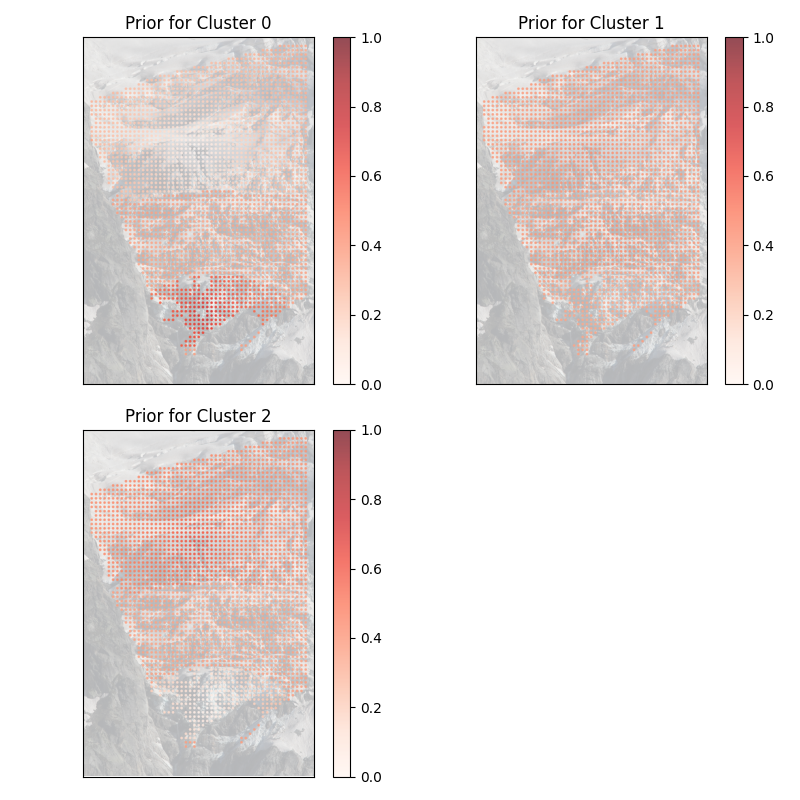

In [29]:
base_name = f"PPCX_mcmc_{camera_name}_{reference_start_date}_{reference_end_date}"

# Run for unsmoothed data
df_run = df.copy()

# Assign spatial priors
prior_probs = assign_spatial_priors(
    x=df_run["x"].to_numpy(),
    y=df_run["y"].to_numpy(),
    polygons=sectors,
    prior_probs=PRIOR_PROBABILITY,
    method="exponential",
    method_kws={"decay_rate": 0.001},
)

fig, axes = plot_spatial_priors(df_run, prior_probs, img=img)
fig.savefig(
    output_dir / f"{base_name}_spatial_priors.jpg",
    dpi=150,
    bbox_inches="tight",
)

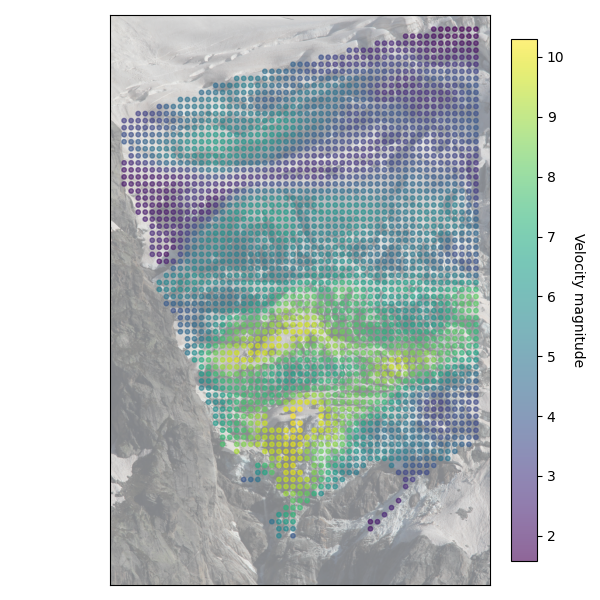

In [30]:
# Plot velocity field
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_velocity_magnitude(
    df_run["x"].to_numpy(),
    df_run["y"].to_numpy(),
    df_run["V"].to_numpy(),
    img=img,
    ax=ax,
)
fig.savefig(
    output_dir / f"{base_name}_velocity_field.jpg",
    dpi=150,
    bbox_inches="tight",
)


In [31]:
# Fit scaler on data
# df_run["log_y"] = np.log(df_run["y"] + 1e-6)
# variables_names = ["V", "log_y"]
variables_names = ["V"]

# Fit scaler on data
scaler = StandardScaler()
scaler.fit(df_run[variables_names].values)
joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
logger.info(
    f"Using features: {variables_names} with shape {df_run[variables_names].shape}"
)

# Scale data for model input
data_array_scaled = scaler.transform(df_run[variables_names].to_numpy())

# diagnostic data before building the model
print("Data statistics after scaling:")
print(f"Mean: {data_array_scaled.mean(axis=0)}")
print(f"Std: {data_array_scaled.std(axis=0)}")
print(f"Min: {data_array_scaled.min(axis=0)}")
print(f"Max: {data_array_scaled.max(axis=0)}")

# Check for outliers
Q1 = np.percentile(data_array_scaled, 25, axis=0)
Q3 = np.percentile(data_array_scaled, 75, axis=0)
print(f"IQR: {Q3 - Q1}")


# print("2D Data statistics after scaling:")
# print(
#     f"V - Mean: {data_array_scaled[:, 0].mean():.3f}, Std: {data_array_scaled[:, 0].std():.3f}"
# )
# print(
#     f"y - Mean: {data_array_scaled[:, 1].mean():.3f}, Std: {data_array_scaled[:, 1].std():.3f}"
# )

# # Check correlation
# correlation = np.corrcoef(data_array_scaled.T)[0, 1]
# print(f"V-y correlation: {correlation:.3f}")

2025-09-24 09:42:26 | [INFO    ] Using features: ['V'] with shape (2619, 1)


Data statistics after scaling:
Mean: [-8.68169818e-17]
Std: [1.]
Min: [-1.94981461]
Max: [2.44475453]
IQR: [1.53973229]


2025-09-24 09:42:29 | [INFO    ] Marginalized mixture model (un-sampled) created.
2025-09-24 09:42:29 | [INFO    ] Starting MCMC sampling...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu, sigma]


Output()

Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 66 seconds.
2025-09-24 09:43:42 | [INFO    ] Sampling completed.
2025-09-24 09:43:48 | [WARNING ] This function is temporary and it will be replaced by a more structured configuration system.
2025-09-24 09:43:48 | [INFO    ] Experiment metadata saved to output/PPCX_Tele_2024-06-29_mcmc/PPCX_mcmc_PPCX_Tele_2024-06-29_2024-06-29_metadata.json


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0, 0]     1.292  0.025   1.246    1.340        0.0      0.0    9838.0   
mu[1, 0]     0.022  0.015  -0.005    0.050        0.0      0.0    8134.0   
mu[2, 0]    -0.998  0.019  -1.035   -0.963        0.0      0.0    9029.0   
sigma[0, 0]  0.515  0.018   0.482    0.550        0.0      0.0    9219.0   
sigma[1, 0]  0.296  0.011   0.274    0.317        0.0      0.0   12530.0   
sigma[2, 0]  0.401  0.014   0.375    0.427        0.0      0.0    9133.0   

             ess_tail  r_hat  
mu[0, 0]       8580.0    1.0  
mu[1, 0]       7693.0    1.0  
mu[2, 0]       9332.0    1.0  
sigma[0, 0]    8183.0    1.0  
sigma[1, 0]    9250.0    1.0  
sigma[2, 0]    8919.0    1.0  


/home/francesco/ppcx/ppcx-domains/src/ppcluster/mcmc.py:716: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(
2025-09-24 09:43:56 | [INFO    ] Postprocessing outputs saved to output/PPCX_Tele_2024-06-29_mcmc


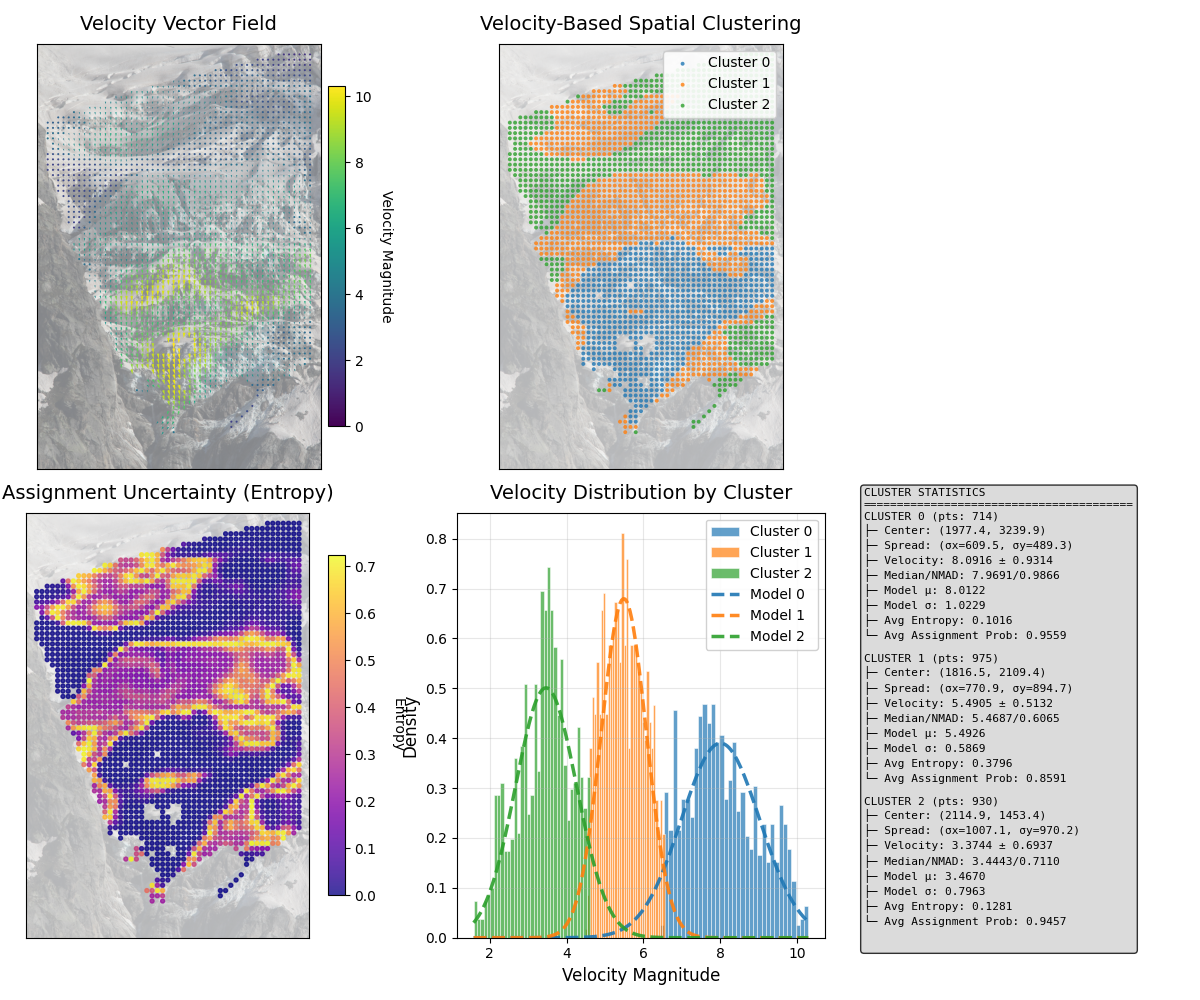

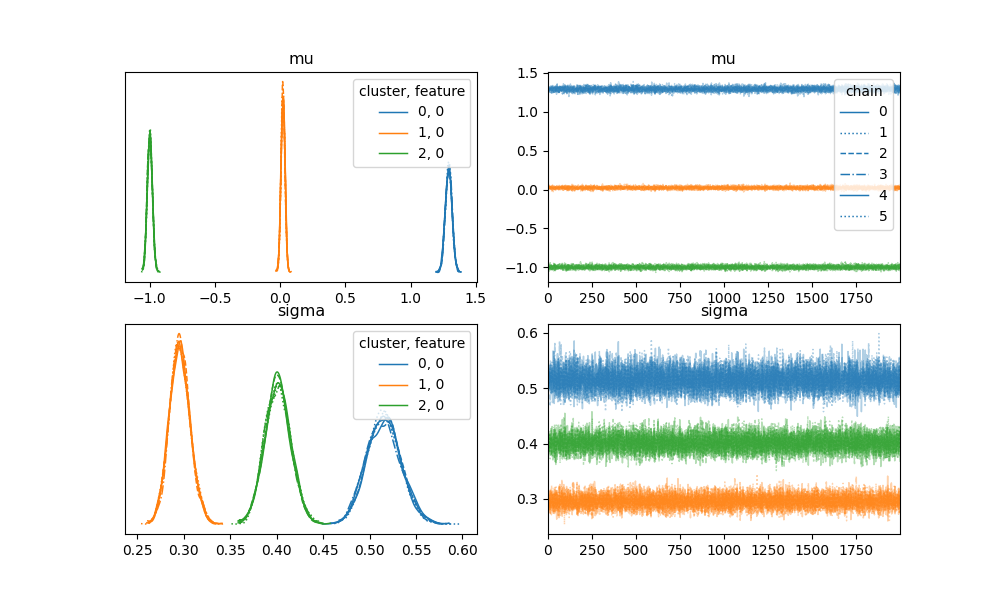

In [32]:
# Build model
model = build_marginalized_mixture_model(
    data_array_scaled,
    prior_probs,
    sectors,
    mu_params={"mu": 0, "sigma": 1},
    sigma_params={"sigma": 2},
    feature_weights=[1.0, 0.3] if len(variables_names) > 1 else None,
)

# Sample model
sample_args = dict(
    target_accept=0.95,
    draws=2000,
    tune=1000,
    chains=6,
    cores=6,
    random_seed=RANDOM_SEED,
)
idata, convergence_flag = sample_model(model, output_dir, base_name, **sample_args)

idata_summary = az.summary(idata, var_names=["mu", "sigma"])
print(idata_summary)

metadata = collect_run_metadata(
    idata=idata,
    convergence_flag=convergence_flag,
    data_array_scaled=data_array_scaled,
    variables_names=variables_names,
    sectors=sectors,
    prior_probs=prior_probs,
    sample_args=sample_args,
    frame=locals(),  # Pass current local variables
)

save_run_metadata(output_dir, base_name, metadata)

# Postprocess results
posterior_probs, cluster_pred, uncertainty = postprocess_mcmc_results(
    idata,
    df_run,
    scaler,
    img,
    output_dir,
    base_name,
)
